<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 5ème projet de ma formation Datascientist dispensée en MOOC par 
**<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>**.
</p>    

<p>
Ce notebook présente un modèle de ségmentation de clients d'un site d'achats en ligne. 
</p>
<p>
Ce modèle se base sur les données fournies par le site :
</p>
<p>
https://archive.ics.uci.edu/ml/datasets/Online+Retail
</p>
<p>
Ce notebook implémente les phases de l'analyse exploratoire de la façon suivante :
</p>
* l'acquisition des données traitées issues des notebook <font color='blue'>P5_2_RFM.ipynb</font>, <font color='blue'>P5_2_NLP.ipynb</font> et <font color='blue'>P5_2_timeFeature.ipynb</font>
* l'analyse exploiratoire des modeles de calcul   
* La recherche des paramètres optimaux pour les algorithmes :
    * de clustering
    * de prédiction par regression et méthodes ensemblistes.
* les mesures de tests des différents modèles
* Le test de prédiction de l'appartenance d'un client à un segment.


**Les résultats de cette analyse sont implémentés dans <font color='blue'>*P5_ModelBuilder*</font>**. 

Ce dernier composant permet construire un composant déployable réalisant des prédictions d'appartenance d'un client à un segment de marché.


In [ ]:
import pandas as pd
import numpy as np
import time

import warnings
warnings.filterwarnings("ignore")


import p3_util
import p3_util_plot
import p5_util
import p5_util_plot

#--------------------------
# Process flow parameters
#--------------------------
is_reloaded = True

#---------------------------------------------------------------------------
# Outliers values issued from Total feature are removed or not from dataset.
is_total_no_outliers = False
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
# Encoded RFM features are clusterized separatly from other features.
#---------------------------------------------------------------------------
is_rfm_cluster = True


dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}


#### <font color='blue'>Restore into *df_invoice_line* dataframe the samples data-set</font>

In [ ]:
import p5_util
if is_reloaded is True:
    df_invoice_line =  p5_util.p5_reload_data_sample(mode='random')
    print(df_invoice_line.shape)    

In [ ]:
nb_invoices = len(df_invoice_line['InvoiceNo'].unique())
print("\n*** Nombre de factures= "+str(nb_invoices))

In [ ]:
nb_customers = len(df_invoice_line['CustomerID'].unique())
print("\n*** Nombre de clients= "+str(nb_customers))

In [ ]:
import p5_util
df_invoice_line['Total'] = df_invoice_line.Quantity *  df_invoice_line.UnitPrice

df_invoice_line.query('Total>0')['InvoiceDate'].sort_values().apply(p5_util.p5_get_month_from_timestamp).unique()

# <font color='blus'>Restore into sepatated dataframes file issues from feature engineering</font>

####  Restore time based features

In [ ]:
import p5_util
fileName = './data/df_customers_timeFeature_pca.dump'
df_customers_timeFeature = p5_util.object_load(fileName)

df_customers_timeFeature.shape

In [ ]:
df_customers_timeFeature.sample(1)

####  Restore RFM features

In [ ]:
import p5_util
fileName = './data/df_customers_RFM.dump'
df_customers_RFM = p5_util.object_load(fileName)

df_customers_RFM.shape

####  Restore NLP features

In [ ]:
import p5_util
fileName = './data/df_customers_pca_nlp.dump'
df_customers_NLP = p5_util.object_load(fileName)

df_customers_NLP.shape

In [ ]:
df_customers_NLP.sample(1)

#### Dataframes aggregation

In [ ]:
import pandas as pd
df_customers = pd.DataFrame()

df_customers = pd.concat([df_customers,df_customers_RFM],  axis=1)
print(df_customers.shape)

df_customers = pd.concat([df_customers,df_customers_timeFeature], join='inner', axis=1)
print(df_customers.shape)

df_customers = pd.concat([df_customers,df_customers_NLP], join='inner', axis=1)
print(df_customers.shape)


#### Backup *df_customers* file 

In [ ]:
import p5_util
fileName = './data/df_customers.dump'
p5_util.object_dump(df_customers, fileName)

# <font color='blus'> Clustering features</font>

#### Loading dumped file into *df_customers* dataframe

In [ ]:
import p5_util
if is_reloaded is True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

## <font color='blue'> Kmeans Clustering / intra-inertia criteria</font>

In [ ]:
import p5_util
cluster_start = 1
cluster_end = 10
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_customers, cluster_start, cluster_end)

#### Save of Kmeans clustering scan into a dumped file

In [ ]:
import p5_util

fileName = './data/clustering_dict_kmeans_ALL.dump'
p5_util.object_dump(dict_kmeans, fileName)

#### Time features : Plot Clusters = F(intra-inertia)

In [ ]:
import p5_util_plot
import p5_util

if is_reloaded is True:
    fileName = './data/clustering_dict_kmeans_ALL.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'Features : Nb. clusters'
x_label_1 = 'Features : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

#### Clustering :  silhouette

In [ ]:
import p5_util
import p5_util_plot

if True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print("Features : "+str(df_customers.shape))
    
    #-------------------------------------------------------------------------------
    # Use kmeans dictionary to get numbers of clusters
    #-------------------------------------------------------------------------------
    fileName = './data/clustering_dict_kmeans_ALL.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Clusters into dict_kmeans= "+str(len(dict_kmeans)))
    cluster_start = list(dict_kmeans.keys())[0]
    cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
    print("Cluster start = "+str(cluster_start)+" Cluster end= "+str(cluster_end))
if 1 == cluster_start:
    cluster_start=2
dict_cluster_kmeans_silhouette = p5_util.kmeans_scan_silhouette(df_customers, cluster_start, cluster_end)

#### Backup silhouette clustering result

In [ ]:
import p5_util
fileName = './data/dict_cluster_kmeans_silhouette_ALL.dump'
p5_util.object_dump(dict_cluster_kmeans_silhouette,fileName)

#### Plotting silhouette = F(nb clusters)

In [ ]:
dict_kmeans

In [ ]:
p_title='Kmeans Silhouette'
p5_util_plot.plot_kmeans_silhouette(dict_cluster_kmeans_silhouette, p_title, p_figsize=(10,10))

### <font color='blue'>Cluster model with best number of clusters</font>

In [ ]:
n_cluster=6

In [ ]:
cluster_kmean = dict_kmeans[n_cluster]
cluster_kmean
if 'cluster' in df_customers:
    del(df_customers['cluster'])
X = df_customers.values
preds_kmean = cluster_kmean.predict(X)

### <font color='blue'>Adding *cluster* issue from clustering into *df_customers*  as a new feature</font>

In [ ]:
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
df_customers.shape,preds_kmean.shape

In [ ]:
import p5_util

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, preds_kmean)
print(df_customers.shape)

### <font color='blue'>Showing elements count per cluster</font>

In [ ]:
import p5_util_plot
p5_util_plot.plot_cluster_frequency(df_customers)

## <font color='blue'> DBSCAN clustering</font>

#### Distances distribution

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
    
distances = pdist(df_customers.values, metric='euclidean')

print(np.min(distances), np.max(distances))



x_med = np.median(distances)
print("Distance median = "+str(x_med))
print("Nb elts de distances= "+str(len(distances)))
len(np.where(distances<x_med)[0])

raws = df_customers.shape[0]
print("Distance elts computing : n*(n+1)/2 - n = "+str(int((raws*(raws+1)/2)-raws)))

df_dist = pd.DataFrame(distances)

df_dist_quantiles = df_dist.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95])

df_dist_quantiles.rename(columns={0:'Distance'},inplace=True)
df_dist_quantiles

In [ ]:
p_eps=31.0

#### Computing nb neighbours for 95% fo distances

In [ ]:
import numpy as np

dist_matrix = squareform(distances)
print(dist_matrix.shape)
dict_ball_neighbour = dict()
for raw in range(0,dist_matrix.shape[0]):
    dict_ball_neighbour[raw] = len(np.where(dist_matrix[raw]<= p_eps)[0])

In [ ]:
ser_ball_neighbour = pd.Series(dict_ball_neighbour)
ser_neighbour_quantiles = ser_ball_neighbour.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95, 1.0])
ser_neighbour_quantiles

#### Apply of DBSCAN clustering

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=p_eps,min_samples=350, n_jobs=3)
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
pred_dbscan =  dbscan.fit_predict(df_customers)

import numpy as np
np.unique(pred_dbscan)

#### DBSCAN : Plot Numbers per cluster

In [ ]:
import p5_util
import p5_util_plot

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_dbscan)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

## <font color='blue'>GMM clustering</font>

#### Restore dataframe with reduced dimensions per customer and encoded values

In [ ]:
import p5_util

if is_reloaded is True:
    fileName = './data/df_customers.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
print(df_customers.shape)    

#### Clustering to search for from a given range of clusters

In [ ]:
cluster_start = 1
cluster_end = 11

#### GMM clustering evaluation : using BIC and AIC criterias
* AIC : provides a measure of statistical quality model. It measures loss of information (increase of entropy)  when multiple models are suggested, models with increaing complexity.
* BIC : comes from AIC

Goal : minimisation of both criterias

#### Cross-validation of GMM hyper-parameter : covariance type.

In [ ]:
import p5_util
dict_hyper_parameter={'covariance_type':['diag','spherical','full']}
t_range_cluster = (cluster_start, cluster_end)
dict_list_gmm_model = p5_util.gmm_hyper_parameter_cv(df_customers, t_range_cluster ,dict_hyper_parameter)

#### Display AIC and BIC considering clusters number

In [ ]:
import p5_util_plot
p_figsize = (14,7)
t_range_cluster = (cluster_start, cluster_end)
p_title = 'GMM clustering'
p5_util_plot.gmm_models_plot_AIC_BIC(df_customers, dict_list_gmm_model, t_range_cluster, p_figsize, p_title)

<font color='red'>Loss of information is optimized for clusters number = 4</font>

#### GMM models evaluation:  computation of silhouette score

In [ ]:
import p5_util
dict_dict_silhouette_score = p5_util.gmm_silhouette_compute(df_customers, dict_list_gmm_model)

#### Plot silhouette score for any type of covariance and for any type of GMM model

* For each covariance type (spherical, diag and full), GMM models ranking from *cluster_start* to *cluster_end* have been built

In [ ]:
import p5_util_plot
p_figsize=(21,14)
areas_raws =1
areas_colums =3
p_title = "GMM : silhouette"
p5_util_plot.gmm_models_plot_silhouette(df_customers, dict_dict_silhouette_score\
, p_figsize, p_title, areas_raws, areas_colums)

* <font color='red'>GMM : Silhouette coef. decreases with number of clusters, whatever hyper-parameters values</font>
* <font color='red'>GMM : hyper-parameters with ``diag`` value has the best performance</font>


#### Selection of best clusters count with optimum covariance type

In [ ]:
p_covariance_type = 'diag'
n_cluster = 6
list_gmm_model = dict_list_gmm_model[p_covariance_type]
for gmm_model in list_gmm_model:
    if n_cluster == gmm_model.n_components:
        break
gmm_model

#### Display number of elements in each cluster due to ``GMM``

In [ ]:
import p5_util
import p5_util_plot
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])

if 'CustomerID' in df_customers.columns:
    del(df_customers['CustomerID'])
    

    
pred_gmm = gmm_model.predict(df_customers.values)
print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_gmm)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

Backup of ``df_customers`` dataframe with added clusters

In [ ]:
import p5_util
p5_util.object_dump(df_customers,'./data/df_customers_cluster.dump')
print(df_customers.shape)
print('cluster' in df_customers.columns)

#### Cluster list selection

In [5]:
list_cluster = [0,2,4]
list_cluster

[0, 2, 4]

# <font color='blus'>Using a supervised M.L. algorithm for market segments prediction</font>

In [6]:
import p5_util
df_customers = p5_util.object_load('./data/df_customers_cluster.dump')
print(df_customers.shape)
print('cluster' in df_customers.columns)

p5_util.object_load : fileName= ./data/df_customers_cluster.dump
(2124, 340)
True


Target vector for supervised ML algorithm is extracted from column ``cluster`` in ``df_customers`` dataframe.

Data belonging to clusters from ``list_cluster``  are extraced.

#### Cluster list selection

In [7]:
list_cluster = [0,2,4]
list_cluster

[0, 2, 4]

In [8]:
import p5_util
df_customers = p5_util.df_customers_cluster_filter(df_customers, list_cluster)

(2124, 340)
(2121, 340)


Dataframe ``df_customers`` is filtered considering ``list_cluster``

In [9]:
import numpy as np

list_all_cluster = np.unique(df_customers.cluster.values)

print(df_customers.shape)

for cluster in list_all_cluster:
    if cluster not in list_cluster:
        df_customers = df_customers[df_customers.cluster != cluster ]

print(df_customers.shape)
y_sample = df_customers.cluster.values
print(y_sample.shape, type(y_sample))

(2121, 340)
(2121, 340)
(2121,) <class 'numpy.ndarray'>


In [10]:
np.unique(y_sample)

array([0, 2, 4])

Dataframe of customers values is used to split data between train and test

In [11]:
from sklearn.model_selection import train_test_split

list_col_drop = ['cluster']
list_col_keep =[col for col in df_customers.columns if col not in list_col_drop]
is_nan_in_arr = np.isnan(df_customers[list_col_keep].values)
print("Nan values : "+str(True in is_nan_in_arr))


X_train, X_test, y_train, y_test = train_test_split(df_customers[list_col_keep].values, y_sample, test_size=0.6)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


Nan values : False
(848, 339) (1273, 339)
(848,) (1273,)


## <font color='blue'>Using *RandomForests* for observations classification into segments</font>

### <font color='blue'>RandomForests : searching for bests parameters </font>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

import p5_util

dict_score_global = dict()
list_estimators = list(np.arange(10,90,10))
list_estimators = list(np.arange(2,21,1))
#list_estimators = [10,20]
nb_repetition = 10
total_score_global = 0.0
nb_segments = len(np.unique(y_sample))

#-------------------------------------------------------------
# dict_score_forest_mean is initialized
#-------------------------------------------------------------
dict_score_forest_mean = dict()

for  nb_estimators in list_estimators:
    print("\n---------------- Random forest classifier : "+str(nb_estimators)+" forests / "+str(nb_repetition)+" repetition(s) ---------------------")
    dict_score_segment_mean = dict()
    #-----------------------------------------------------------------------
    # Each cluster is identified as a market segment
    #-----------------------------------------------------------------------
    for segment in list_cluster:
        dict_score_segment_mean[segment] = 0.0
        
    for repeat in range(0,nb_repetition):
        rfc = RandomForestClassifier(n_estimators=nb_estimators)
        rfc_model = rfc.fit(X_train, y_train)
        y_pred = rfc_model.predict(X_test)

        #------------------------------------------------------
        # dict_score_segment contains accuracy for any segment.
        #------------------------------------------------------
        score_global, dict_score_segment = p5_util.compute_precision_per_segment(y_test, y_pred,list_cluster)  
        
        #-------------------------------------------------------
        # Accuracy per segment and per repetition is accumulated 
        #-------------------------------------------------------
        for segment, accuracy in dict_score_segment.items():
            dict_score_segment_mean[segment] += accuracy
            
        dict_score_global[nb_estimators] = score_global
        total_score_global += score_global
    #----------------------------------------------------------
    # At end of repetitions, mean accuracy per segment is computed
    #----------------------------------------------------------
    total_score_global /= nb_repetition
    for segment, accuracy in dict_score_segment_mean.items():
        dict_score_segment_mean[segment] /= nb_repetition
    #----------------------------------------------------------
    # Mean accuracy for a forest is stored
    #----------------------------------------------------------
    dict_score_forest_mean[nb_estimators] = (dict_score_segment_mean,total_score_global)
    total_score_global = 0.0
    #print("\nGlobal segment precision: {0:1.2F}".format(total_score_global))
    #print("----------------------------------------------------------------------------------------------\n")


### <font color='blue'>Display accuracy per segment and global accuracy</font>

In [ ]:
import numpy as np
list_forests = list()
list_global_accuracy = list()
list_segment_accuracy = list()

for forest, (dict_segment_accuracy, global_accuracy) in dict_score_forest_mean.items():
    
    print("\n----------------- Forests : "+str(forest)+" / Repetitions : "+str(nb_repetition)+" -----------------")
    print("Global accuracy = {}".format(np.format_float_positional(global_accuracy, precision=2)))
    list_forests.append(forest)
    list_global_accuracy.append(global_accuracy)
    for segment, accuracy in dict_segment_accuracy.items():
        if segment in list_cluster:
            print("Segment : {0} / Mean accuracy for {1} repetitions : {2:0.2F}".format(segment,nb_repetition,accuracy))
    print("-------------------------------------------------------------------------\n")

### <font color='blue'>Plot accuracy per segment and global accuracy</font>

In [ ]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True)

dict_forest_segment_accuracy = dict()

for segment in list_cluster:
    list_forest_segment_accuracy = list()
    for forest, (dict_segment_accuracy, global_accuracy) in dict_score_forest_mean.items():
        segment_accuracy = dict_segment_accuracy[segment]
        list_forest_segment_accuracy.append(segment_accuracy)
    dict_forest_segment_accuracy[segment] = list_forest_segment_accuracy
    list_forest_segment_accuracy = None         
        
#for segment, list_forest_segment_accuracy in dict_forest_segment_accuracy.items():
title = 'Segment 0'
if True:
    row = 0
    col = 0
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[0])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if False:
    row = 0
    col = 1
    title = 'Segment 1'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[1])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if True:
    row = 0
    col = 1
    title = 'Segment 2'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[2])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if False:
    row = 0
    col = 1
    title = 'Segment 3'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[3])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

if True:
    row = 1
    col = 0
    title = 'Segment 4'
    axes[row,col].plot(list_forests, dict_forest_segment_accuracy[4])
    axes[row,col].set_title(title)
    axes[row,col].set_xlabel('Nb forests')
    axes[row,col].set_ylabel('Precision')

row = 1
col = 1
title = 'All segments'
axes[row,col].plot(list_forests, list_global_accuracy, color='red')
axes[row,col].set_title(title)
axes[row,col].set_xlabel('Nb forests')
axes[row,col].set_ylabel('Precision')

plt.plot()

<font color='red'>Nombre optimal d'estimateurs :  18</font>

### <font color='blue'>Random Forest :features importancy </font>

In [ ]:
import p3_util_plot

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

p_threshold = 0.001
select = SelectFromModel(rfc_best_model, prefit=True, threshold=p_threshold)
print(X_train.shape)
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)
print(X_train2.shape)
rfc_reduced = RandomForestClassifier(n_estimators=19).fit(X_train2, y_train)


pred = rfc_reduced.predict(X_test2)
#score = metrics.accuracy_score(y_test, y_pred)
p3_util_plot.printmd("Random forest precision with importance threshold= "+str(p_threshold)+" : "+str(accuracy_score(y_test, pred)))

For 30% feaures less, decrease of accuracy is sensible. It is decided to keep model with 339 features.

### <font color='blue'>Random Forest : confusion matrix for each of the clusters</font>

Optimal RF model trained with ``(X_train, y_train)`` is used.

In [ ]:
nb_estimators=19

In [ ]:
nb_estimators
rfc = RandomForestClassifier(n_estimators=nb_estimators)
rfc_best_model = rfc.fit(X_train, y_train)

Get customerID from ``y_test`` for each one the clusters

In [ ]:
import numpy as np
for cluster in list_cluster:
    
    y_true_index = np.where(y_sample==cluster)[0]
    y_true = y_sample[y_true_index]
    print(cluster, y_true.shape)
    #print(y_true.shape)
y_true.shape

In [ ]:
from sklearn import metrics
y_pred = rfc_best_model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

#---------------------------------------------------------------------------------
# Following function is extraced from URl :
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#---------------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, color='blue', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color='blue')
    plt.xlabel('Predicted label', color='blue')
    return cm

In [ ]:
from sklearn import metrics
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for RF predictions, 60% tests')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [ ]:
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 0+68
FN = 2+108
TP = 725
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 2 + 27
FN = 4 + 0
TP = 107
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 108+4
FN = 68+27
TP = 232
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

## <font color='blue'>Using SVC for observations classification into segments</font>

In [ ]:
import p5_util
import sklearn

dict_svm_model = dict()
list_svm_kernel = ['rbf','linear','poly','sigmoid']
for p_kernel in list_svm_kernel:
    svm_model = sklearn.svm.SVC(kernel=p_kernel)
    svm_model.fit(X_train, y_train)
    dict_svm_model[p_kernel] = svm_model

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)




#------------------------------------------------------
# dict_score_segment contains accuracy for any segment.
#------------------------------------------------------
dict_score_global_svm = dict()
dict_dict_score_segment_svm = dict()
nb_segments = len(np.unique(y_sample))

for p_kernel, svm_model in dict_svm_model.items():    
    y_pred = svm_model.predict(X_test)
    score_global_svm, dict_score_segment_svm \
    = p5_util.compute_precision_per_segment(y_test, y_pred,list_cluster)  
    dict_score_global_svm[p_kernel] = score_global_svm
    dict_dict_score_segment_svm[p_kernel] = dict_score_segment_svm
    print("\nSVC : kernel= "+str(p_kernel)+"\nAccuracy / segment : {} \nGlobal accuracy : {}".format(dict_score_segment_svm, score_global_svm))

### <font color='blue'>SVC : confusion matrix for each of the clusters</font>

In [ ]:
from sklearn import metrics

svm_model = dict_svm_model['linear']
y_pred = svm_model.predict(X_test)
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for SVC predictions, 60% tests')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [ ]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 1+63
FN = 19+62
TP = 729
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 19 + 63
FN = 24 + 1
TP = 54
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 63+63
FN = 62+24
TP = 258
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity))

## <font color='blue'>Using LinearSVC for observations classification into segments</font>

In [45]:
print(X_train.shape, y_train.shape),print(X_test.shape, y_test.shape)

(848, 339) (848,)
(1273, 339) (1273,)


(None, None)

In [39]:
import numpy as np

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import p5_util
#LinearSVC(penalty=’l2’, loss=’squared_hinge’, dual=True, tol=0.0001, C=1.0, multi_class=’ovr’\
#, fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

dict_params = {'C': np.logspace(-3, 3, 7) }
#dict_params = {'C': np.logspace(-3, 3, 7)}

print(dict_params['C'])

lsvc_model = LinearSVC(loss='squared_hinge', penalty='l1', dual=False)
lsvc_model_gscv = GridSearchCV(lsvc_model, dict_params, cv=10)
lsvc_model_gscv.fit(X_train, y_train)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print(lsvc_model_gscv.best_params_)

{'C': 1000.0}


### <font color='blue'>LinearSVC : confusion matrix for each of the clusters</font>

In [53]:
dict_order_segment={0:0,2:1,4:2}
segment=0


757

LinearSVC(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
Confusion matrix, without normalization
[[757   7   6]
 [  3 127  30]
 [  6  44 293]]


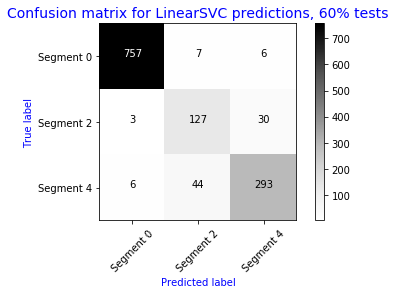

In [49]:
import matplotlib.pyplot as plt
from sklearn import metrics

lsvc_model = LinearSVC(C=1000.0,loss='squared_hinge', penalty='l1', dual=False)
print(lsvc_model)

lsvc_model.fit(X_train, y_train)
y_pred = lsvc_model.predict(X_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
confusion_matrix = plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for LinearSVC predictions, 60% tests')


plt.show()

In [54]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 7+6
FN = 3+64
TP = 757
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 3 + 30
FN = 7 + 44
TP = 127
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 6+44
FN = 30+6
TP = 293
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

Segment : 0 : Recall= 0.9186893203883495 Precision= 0.9831168831168832 F-mesure= 0.9498117942283564 Specifity= 0.9710467706013363

Segment : 2 : Recall= 0.7134831460674157 Precision= 0.79375 F-mesure= 0.7514792899408284 Specifity= 0.9698630136986301

Segment : 4 : Recall= 0.8905775075987842 Precision= 0.8542274052478134 F-mesure= 0.8720238095238095 Specifity= 0.9470338983050848



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Confusion matrix, without normalization
[[728  17  25]
 [ 14 108  38]
 [ 67  50 226]]


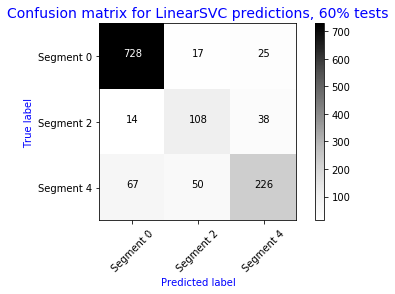

In [42]:
import matplotlib.pyplot as plt
from sklearn import metrics

lsvc_model = LinearSVC(C=1.0)
print(lsvc_model)
lsvc_model.fit(X_train, y_train)
y_pred = lsvc_model.predict(X_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for LinearSVC predictions, 60% tests')


plt.show()

In [25]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 17+27
FN = 14+64
TP = 726
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 14 + 39
FN = 17 + 49
TP = 107
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 64+49
FN = 27+39
TP = 230
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

Segment : 0 : Recall= 0.9029850746268657 Precision= 0.9428571428571428 F-mesure= 0.9224904701397713 Specifity= 0.906183368869936

Segment : 2 : Recall= 0.6184971098265896 Precision= 0.66875 F-mesure= 0.6426426426426426 Specifity= 0.9518181818181818

Segment : 4 : Recall= 0.777027027027027 Precision= 0.6705539358600583 F-mesure= 0.7198748043818466 Specifity= 0.8843398157625384



## <font color='blue'>Using LinearSVC for observations classification into segments</font>

In [45]:
print(X_train.shape, y_train.shape),print(X_test.shape, y_test.shape)

(848, 339) (848,)
(1273, 339) (1273,)


(None, None)

In [39]:
import numpy as np

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import p5_util
#LinearSVC(penalty=’l2’, loss=’squared_hinge’, dual=True, tol=0.0001, C=1.0, multi_class=’ovr’\
#, fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

dict_params = {'C': np.logspace(-3, 3, 7) }
#dict_params = {'C': np.logspace(-3, 3, 7)}

print(dict_params['C'])

lsvc_model = LinearSVC(loss='squared_hinge', penalty='l1', dual=False)
lsvc_model_gscv = GridSearchCV(lsvc_model, dict_params, cv=10)
lsvc_model_gscv.fit(X_train, y_train)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print(lsvc_model_gscv.best_params_)

{'C': 1000.0}


In [53]:
dict_order_segment={0:0,2:1,4:2}
segment=0


757

LinearSVC(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
Confusion matrix, without normalization
[[757   7   6]
 [  3 127  30]
 [  6  44 293]]


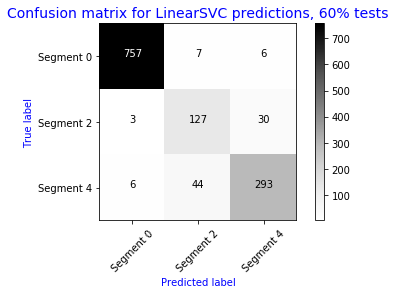

In [49]:
import matplotlib.pyplot as plt
from sklearn import metrics

lsvc_model = LinearSVC(C=1000.0,loss='squared_hinge', penalty='l1', dual=False)
print(lsvc_model)

lsvc_model.fit(X_train, y_train)
y_pred = lsvc_model.predict(X_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
confusion_matrix = plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for LinearSVC predictions, 60% tests')


plt.show()

In [54]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 7+6
FN = 3+64
TP = 757
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 3 + 30
FN = 7 + 44
TP = 127
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 6+44
FN = 30+6
TP = 293
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

Segment : 0 : Recall= 0.9186893203883495 Precision= 0.9831168831168832 F-mesure= 0.9498117942283564 Specifity= 0.9710467706013363

Segment : 2 : Recall= 0.7134831460674157 Precision= 0.79375 F-mesure= 0.7514792899408284 Specifity= 0.9698630136986301

Segment : 4 : Recall= 0.8905775075987842 Precision= 0.8542274052478134 F-mesure= 0.8720238095238095 Specifity= 0.9470338983050848



## <font color='blue'>Using LogisticRegression for observations classification into segments</font>

In [70]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [75]:
import numpy as np

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import p5_util


dict_params = {'C': np.logspace(-3, 3, 7),'penalty':['l1',], 'dual':[False, ] }

print(dict_params['C'])

lr_model = LogisticRegression()

lr_model_gscv = GridSearchCV(lr_model, dict_params, cv=10)
lr_model_gscv.fit(X_train, y_train)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1'], 'dual': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
print(lr_model_gscv.best_params_)

{'C': 1000.0, 'dual': False, 'penalty': 'l1'}


LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Confusion matrix, without normalization
[[768   1   1]
 [  7 120  33]
 [  6  48 289]]


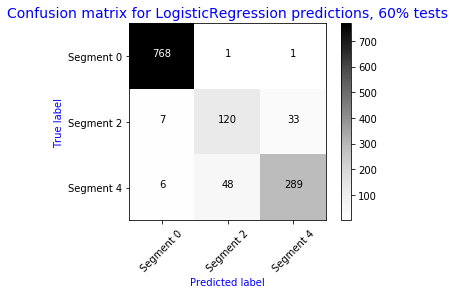

In [77]:
import matplotlib.pyplot as plt
from sklearn import metrics

lr_model = LogisticRegression(C=1000.0,penalty='l1',dual=False)
print(lr_model)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,2,4])
np.set_printoptions(precision=2)
class_names=['Segment 0','Segment 2','Segment 4']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,  title='Confusion matrix for LogisticRegression predictions, 60% tests')


plt.show()

In [61]:
cnf_matrix.ravel()
dict_crit_perf= dict()
#---------------------------------------
# Segment 0
#---------------------------------------
segment = 0
FP = 19+24
FN = 14+64
TP = 727
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[0] = dict_segment

#---------------------------------------
# Segment 2
#---------------------------------------
segment = 2
FP = 14 + 40
FN = 19 + 52
TP = 106
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

#---------------------------------------
# Segment 4
#---------------------------------------
segment = 4
FP = 64+52
FN = 24+40
TP = 227
TN = y_test.shape[0]-(FP + FN + TP)
dict_segment = dict()
dict_segment['FP'] = FP
dict_segment['FN'] = FN
dict_segment['TP'] = TP
dict_segment['TN'] = TN

dict_crit_perf[segment] = dict_segment

for segment in dict_crit_perf.keys():
    dict_segment = dict_crit_perf[segment]
    
    recall = dict_segment['TP']/(dict_segment['TP']+dict_segment['FN'])
    precision = dict_segment['TP']/(dict_segment['TP']+dict_segment['FP'])
    fmesure = (2*dict_segment['TP'])/(2*dict_segment['TP']+dict_segment['FP']+dict_segment['FN'])
    specificity = dict_segment['TN']/(dict_segment['FP']+dict_segment['TN'])
    
    print("Segment : "+str(segment)+" : Recall= "+str(recall)+" Precision= "+str(precision)+" F-mesure= "+str(fmesure)+" Specifity= "+str(specificity)+"\n")

Segment : 0 : Recall= 0.9031055900621118 Precision= 0.9441558441558442 F-mesure= 0.9231746031746032 Specifity= 0.9081196581196581

Segment : 2 : Recall= 0.5988700564971752 Precision= 0.6625 F-mesure= 0.629080118694362 Specifity= 0.9507299270072993

Segment : 4 : Recall= 0.7800687285223368 Precision= 0.6618075801749271 F-mesure= 0.7160883280757098 Specifity= 0.8818737270875764



# <font color='blus'>Clusters analysis</font>

#### <font color='blue'>Restore ``df_invoice_line`` and ``df_customers_cluster`` dataframes</font>

In [ ]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    df_invoice_line = p5_util.p5_reload_data_sample()
    print(df_invoice_line.shape)  
n_cluster=6

import p5_util
if is_reloaded is True:
    
    df_customers = p5_util.object_load('./data/df_customers_cluster.dump')
    print(df_customers.shape)
    print("Cluster into df_customers : "+str('cluster'in df_customers.columns))

In [ ]:
df_invoice_line.CustomerID.unique().shape

In [ ]:
import p3_util_plot
p3_util_plot.printmd("Cluster count : "+str(df_customers.cluster.unique().shape[0]))

### POD activity per cluster

``POD`` feature is added into ``df_invoice_line`` dataframe column

In [ ]:
import p5_util
if 'POD' not in df_invoice_line.columns:
    df_invoice_line['POD'] = df_invoice_line['InvoiceDate'].apply(p5_util.p5_get_pod_from_timestamp)
df_invoice_line.sample(1)

``cluster`` column is addad to ``df_invoice_line``

In [ ]:
if 'CustomerID' not in df_customers.columns:
    print('cluster' in df_customers.columns)
    df_customers.reset_index(inplace=True)


if 'cluster' in df_invoice_line.columns:
    del(df_invoice_line['cluster'])

df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')
df_invoice_line.sample()

Clusters are filetered considering ``list_cluster``

In [ ]:
print(list_cluster)
df_invoice_line.cluster.unique()

In [ ]:
for cluster in list_cluster:
    print(df_invoice_line[df_invoice_line.cluster==cluster].shape)

In [ ]:
import p5_util
df_invoice_line = p5_util.df_cluster_filter(df_invoice_line, list_cluster)
print("Nb customers : " +str(df_invoice_line.CustomerID.unique().shape[0]))
print("list of filtered clusters : " +str(list_cluster))

In [ ]:
#df_invoice_line.groupby(['cluster','POD'])['POD'].size().plot(kind='bar',stacked=True)
z_ = df_invoice_line.groupby(['cluster','POD'])['POD'].size().plot(kind='bar',title='POD per cluster')

### Month activity per cluster

In [ ]:
import p5_util
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

``Month`` feature is added into ``df_invoice_line`` dataframe column

In [ ]:
import p5_util
if 'Month' not in df_invoice_line.columns:
    df_invoice_line['Month'] = df_invoice_line['InvoiceDate'].apply(p5_util.p5_get_month_from_timestamp)
df_invoice_line.sample(1)

``cluster`` column is added to ``df_invoice_line``

In [ ]:
'cluster' in df_customers.columns

In [ ]:
if 'CustomerID' not in df_customers.columns:
    print('cluster' in df_customers.columns)
    df_customers.reset_index(inplace=True)

if 'cluster' in df_customers.columns:
    del(df_invoice_line['cluster'])

df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')
df_invoice_line.sample()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

feature = 'Month'
cluster = 0
df = df_invoice_line[df_invoice_line.cluster==cluster].groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})
df = df.apply(lambda x: x/sum(x))
df.rename(columns={'InvoiceNo':'%Nb Invoices'}, inplace=True)
dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df.rename(dict_month_name,axis='index', inplace=True)

z_ = plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlabel('Months')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

df.plot(kind='bar', ax=axes, color='green', title='Monthly activity for cluster '+str(cluster))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#z_ = plt.figure(figsize=(10,10))
#axes = plt.gca()

feature = 'Month'
list_color=['grey','red','blue']
cluster = 3
i_color = 0
for cluster in list_cluster:
    df = df_invoice_line[df_invoice_line.cluster==cluster].groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})
    df = df.apply(lambda x: x/sum(x))
    df.rename(columns={'InvoiceNo':'%Nb Invoices cluster '+str(cluster)}, inplace=True)
    df.rename(dict_month_name,axis='index', inplace=True)

    axes.set_xlabel('Months')
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())

    #df.plot(kind='bar', ax=axes, color=list_color[i_color], title='Monthly activity for cluster '+str(cluster))
    df.plot(kind='bar', color=list_color[i_color], title='Monthly activity for cluster '+str(cluster))
    i_color += 1

In [ ]:
df_ = df_invoice_line.groupby(['cluster','Month']).agg({'Month': lambda x:len(x)})
df_.rename(columns={'Month':'MonthActivity'}, inplace=True)
df_.reset_index(inplace=True)
df_.sample()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
ax = plt.gca()

df_invoice_line.groupby(['cluster','Month'])['Month'].size().unstack().plot(kind='bar',stacked=True, ax=ax)

In [ ]:
dict_month_name

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_ = df_invoice_line.groupby(['cluster','Month']).agg({'Month': lambda x:len(x)})
df_.rename(columns={'Month':'MonthActivity'}, inplace=True)
df_.reset_index(inplace=True)
df_.sample()

df_.rename(columns=dict_month_name, inplace=True)

print(df_.sample())
# gca stands for 'get current axis'
ax = plt.gca()
for cluster in list_cluster:
    df_.rename(dict_month_name,axis='index', inplace=True)
    df_[df_.cluster==cluster].plot(kind='line',x='Month',y='MonthActivity',ax=ax)



plt.show()

In [ ]:
df_.sample()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm

color = cm.inferno_r(np.linspace(.2,.9, 12))
color = np.vstack((color[:12],color[:12]))
color = np.vstack((color[:24],color[:24]))
color = np.vstack((color[:48],color[:24]))

print(color.shape)
plt.figure(figsize=(14,14))


df_.query("cluster==0 or cluster==2 or cluster==4")['MonthActivity'].plot(kind='bar',  color=color)
plt.show()

### POD activity by cluster

#### POD activity distribution

In [ ]:
import seaborn as sns

with sns.axes_style('white'):
    g = sns.factorplot("POD", data=df_invoice_line, aspect=2, kind="count", color='steelblue')

#### POD=1 activity dispersion per cluster

In [ ]:
import p5_util_plot
#----------------------------------------------------------------------------------
# Restrict dataframe to POD activity value 1 (in working hours)
#----------------------------------------------------------------------------------
df_pod_customers = df_invoice_line[df_invoice_line.POD==1]

feature = 'POD'
new_feature = 'TotalPOD'
lambda_func = lambda x:len(x)
plot_cond = ''
y_label = None
title = "Working hours activity per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_pod_customers, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

#### POD=2 activity dispersion per cluster

In [ ]:
import p5_util_plot
#----------------------------------------------------------------------------------
# Restrict dataframe to POD activity value 2 (out of working hours)
#----------------------------------------------------------------------------------
df_pod_customers = df_invoice_line[df_invoice_line.POD==2]

feature = 'POD'
new_feature = 'TotalPOD'
lambda_func = lambda x:len(x)
plot_cond = ''
y_label = None
title = "Out of working hours activity per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_pod_customers, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

Behaviours considering POD activity are similar from one cluster to another.

### Monthly incomes by cluster

Data sample and dataframe customer model are reloaded.

In [ ]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    df_invoice_line = p5_util.p5_reload_data_sample()
    print(df_invoice_line.shape)  

import p5_util
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

Build dataframe ``df_monthy_incomes``

In [ ]:
df_monthly_incomes = p5_util.df_monthly_incomes_build(df_invoice_line, df_customers, dict_month_name)

``cluster`` column is added to monthy incomes

In [ ]:
df_monthly_incomes = p5_util.df_add_cluster(df_monthly_incomes, df_customers.cluster)

In [ ]:
if 'CustomerID' in df_customers.columns:
    df_customers.index = df_customers.CustomerID
    del(df_customers['CustomerID'])

#### Display effective for each cluster

In [ ]:
# Effective per cluser
df = df_monthly_incomes.groupby('cluster').agg({'cluster':lambda x:len(x)})
df['Effective'] = df.cluster
del(df['cluster'])
print(df)

### Incomes

#### Plot of monthly incomes considering clusters

In [ ]:
import p5_util_plot
p5_util_plot.df_monthly_incomes_plot(df_monthly_incomes, dict_month_name, list_cluster)

Monthly incomes shows differences between clusters : 

* Cluster 0 generates the less incomes
* Cluster 2 generates most incomes
* Cluster 4 show incomes between cluster 0 and 2

#### Plot monthly incomes dispersion for each cluster

In [ ]:
if 'CustomerID' not in df_customers.columns:
    df_customers['CustomerID'] = df_customers.index

**Plot distribution of incomes per customer for each cluster.**

Dataframe ``df_incomes_cluster`` is  a table containing total incomes for each of the customers. 

Each customer is assigned a cluster.

In [ ]:
import p5_util_plot

df_incomes_cluster = df_invoice_line.groupby(['CustomerID']).agg({'Total': lambda x:sum(x)})
df_incomes_cluster.rename(columns={'Total':'Incomes'}, inplace=True)
df_incomes_cluster.reset_index(inplace=True)


feature = 'Incomes'
new_feature = 'TotalIncomes'
lambda_func = lambda x:sum(x)
plot_cond = ''
y_label = None
title = "Incomes per customer for each cluster"

p5_util_plot.df_plot_feature_cluster(df_incomes_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

In [ ]:
plot_cond = 'TotalIncomes<=5000'
p5_util_plot.df_plot_feature_cluster(df_incomes_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Creates generic dataframe ``df_cluster`` from ``df_invoice_line``.**

``df_invoice_line`` dataframe is the sampled dataset.

``df_cluster`` dataframe is issued from ``df_invoice_line`` dataframe. It compounds information over numbers of invoices and number of invoices lines per invoice.

``df_cluster`` is used to plot distributions of invoices per customer and invoice lines per customer, such, for each cluster.


In [ ]:
import p3_util_plot

df_cluster = df_invoice_line.groupby(['CustomerID','InvoiceNo']).agg({'InvoiceNo': lambda x:len(x)})
df_cluster.rename(columns={'InvoiceNo':'InvoiceLineCount'}, inplace=True)
df_cluster.reset_index(inplace=True)

**Plot distribution of invoices count per customer for each cluster.**

In [ ]:
import p5_util_plot

feature = 'InvoiceNo'
new_feature = 'InvoiceCount'
lambda_func = lambda x:len(x)
plot_cond = ''
title = "Invoice count per customer"
y_label = None

#df_feature_cluster = df.groupby(['CustomerID']).agg({feature: lambda_func})
if True:
    p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
    , lambda_func, plot_cond, y_label, title)

In [ ]:
plot_cond = 'InvoiceCount<20'
p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of invoice lines count per customer for each cluster.**

In [ ]:
import p5_util_plot

feature = 'InvoiceLineCount'
new_feature = 'InvoiceLineCount'
lambda_func = lambda x:sum(x)
plot_cond = ''
y_label = "Invoice lines count per customer"
title = y_label

p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

In [ ]:
plot_cond = 'InvoiceLineCount<400'
p5_util_plot.df_plot_feature_cluster(df_cluster, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of quantities of items per customer for each cluster.**

In [ ]:
import p5_util_plot

feature = 'Quantity'
new_feature = 'ItemQuantities'
lambda_func = lambda x:sum(x)
plot_cond = 'ItemQuantities<2500'
title = "Items quantities per customer"
y_label = None

p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

In [ ]:
plot_cond = ''
p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

**Plot distribution of mean of items unit price per customer for each cluster**.

In [ ]:
import p5_util_plot
feature = 'UnitPrice'
new_feature = 'UnitPriceMean'
lambda_func = lambda x:sum(x)/len(x)
plot_cond = 'UnitPriceMean<10'
title = "Mean Unit Price per customer"
y_label = None
p5_util_plot.df_plot_feature_cluster(df_invoice_line, df_customers, feature,new_feature, list_cluster\
, lambda_func, plot_cond, y_label, title)

#### Total incomes per customer considering clusters

Sub-total is computed per line of invoice.

In [ ]:
import seaborn as sns
import pandas as pd

import p5_util

df_invoice_line['SubTotal'] = df_invoice_line['UnitPrice'] * df_invoice_line['Quantity']

#----------------------------------------------------------------------------
# Total incomes per customer is computed grouping customers and making sum 
# of SubTotal column.
#----------------------------------------------------------------------------
df_total_cluster = df_invoice_line.groupby(['CustomerID']).agg({'SubTotal': lambda x:sum(x)})

df_total_cluster.rename(columns={'SubTotal':'Total'}, inplace=True)
df_total_cluster.reset_index(inplace=True)


df_total_cluster = p5_util.df_cluster_list_add(df_total_cluster, df_customers, list_cluster)
print(df_total_cluster.cluster.unique())


axes = sns.violinplot(y='Total', x='cluster', 
                 data=df_total_cluster, 
                 width=0.5,
                 palette="colorblind")
axes.set_xlabel('Clusters')
axes.set_ylabel('Total per customer')
plt.grid(True)

#### Differentiation over StockCode

In [ ]:
import pandas as pd

df_invoice_line.StockCode.unique().shape
if 'CustomerID' not in df_invoice_line.columns:
    df_customers.reset_index(inplace=True)

if 'cluster' not in  df_invoice_line.columns:   
    df_invoice_line = pd.merge(df_invoice_line, df_customers[['CustomerID','cluster']], on='CustomerID')

df_invoice_line.columns

In [ ]:
import p3_util_plot
print(list_cluster)
for cluster in list_cluster:
    p3_util_plot.printmd("Stock code count for cluster "+str(cluster)+" = "+str(  df_invoice_line.query("cluster=="+str(cluster) ).StockCode.unique().shape[0]))

p3_util_plot.printmd("Stock code count for whole sampling : "+str(df_invoice_line.StockCode.unique().shape[0]))
    

### <font color='blue'> RFM distribution from inside clusters </font>

#### Loading RFM dataframe per customer

In [ ]:
import pandas as pd
import p5_util

fileName = './data/df_RFM.dump'
df_RFM = p5_util.object_load(fileName)

#print(df_RFM.shape)
df_RFM.index = df_RFM.CustomerID
del(df_RFM['CustomerID'])
#print(df_RFM.sample(1))

fileName = './data/df_customers.dump'
df_customers = p5_util.object_load(fileName)

df_customers = p5_util.df_add_cluster(df_customers, pred_gmm)

df_RFM = pd.concat([df_RFM,df_customers['cluster']],axis=1, join='inner')



#### Build arrays of indexes for each cluster

In [ ]:
dict_cluster_index = dict()
for i_cluster in range(0,n_cluster,1):
    dict_cluster_index[i_cluster] = df_RFM[df_RFM.cluster==i_cluster].index

#### Plot RFM distributions per cluster

In [ ]:
df_RFM.columns, df_customers.shape

In [ ]:
df_RFM.columns

In [ ]:
list_cluster
#n_cluster

In [ ]:
plt.figure(figsize=(20,20))  # create a plot figure

dict_df = dict()
ylabel = 'Frequence'
xlabel = "RFM categories"
i_panel = 1
for cluster, arr_cluster_index in dict_cluster_index.items():
    if cluster in list_cluster:
        title = "Cluster "+str(cluster)+" : RFM"
        df = df_RFM.loc[arr_cluster_index,:]
        plt.subplot(3, 1, i_panel) # (rows, columns, panel number)
        i_panel += 1
        plt.hist(df.RFM, color='steelblue', histtype='stepfilled', label='Cluster '+str(cluster), bins=100)
        plt.legend()
    #p3_util_plot.ser_hist(df.RFM,title,xlabel, ylabel,param_bins=100, param_font_size=12, \
    #         param_rotation=90,figsize=(10,10))


# <font color='blues'>Ploting data points</font>

## <font color='blue'>Dimension shift with linear PCA</font>

In [ ]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

In [ ]:
df_customers.columns

In [ ]:
import p5_util
list_col = [col for col in df_customers.columns if col not in ['cluster']]
df_customers = p5_util.df_cluster_filter(df_customers, list_cluster)

In [ ]:
import p3_util_plot
is_pca_plot = True
if is_pca_plot is True:
    z__ = p3_util_plot.df_pca_all_plot(df_customers[list_col], plot=True)

In [ ]:
import p5_util

print(df_customers[list_col].shape)
n_dim = 2
root_name = 'pca_'
df_customers_pca, pca = p5_util.df_pca_reduce(df_customers[list_col]\
                                            , n_dim, root_name, p_is_scale=False)
print(df_customers_pca.shape)


In [ ]:

#len(list_cluster)

In [ ]:
import p3_util_plot
cluster_labels = df_customers.cluster.values

nclusters = len(df_customers.cluster.unique())
title = "Reduced with PCA"
X_plot  = df_customers_pca.values
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

## <font color='blue'>Dimension shift with t-SNE</font>

tSNE allows to build separate groups of data points based on probability points of same group 
belongs to same neighborhood.

This is also an easy way to apply clustering based on this dimension reduction.

In [ ]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    fileName = './data/df_customers_cluster.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

Only points with cluster value in ``list_cluster`` are extracted from ``df_customers``

In [ ]:
df_customers = p5_util.df_customers_cluster_filter(df_customers, list_cluster)

Data values are extracted from clusterised dataframe.

In [ ]:
list_col_keep = [col for col in df_customers.columns if col not in ['cluster']]
df_customers[list_col_keep].columns
X_std = df_customers[list_col_keep].values

T-SNE is applied for a range of perplexities values.

In [ ]:
import p5_util
my_list_tsne_perplexity=[var for var in range(5,55,5)]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=1000, list_tsne_perplexity=my_list_tsne_perplexity)

In [ ]:
import p5_util_plot
nb_col = 4     
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col)

In [ ]:
df_customers.cluster.unique()

In [ ]:
import p3_util_plot
#def this_clustering_plot():
cluster_labels = df_customers.cluster.values
nclusters = len(list_cluster)
best_perplexity = 45
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

#### A sample of data values are extracted from clusterised dataframe.

In [ ]:
sample_ratio = int(df_customers[list_col_keep].shape[0]*0.2)
sample_ratio
df_customers_sample = df_customers[list_col_keep].sample(sample_ratio)
X_std = df_customers_sample.values

T-SNE is applied for a range of perplexities values.

In [ ]:
import p5_util
my_list_tsne_perplexity=[var for var in range(5,55,5)]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=3000, list_tsne_perplexity=my_list_tsne_perplexity)

In [ ]:
import p5_util_plot
nb_col = 4     
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col)

In [ ]:
import p3_util_plot
#def this_clustering_plot():
cluster_labels = df_customers.cluster.values
nclusters = len(list_cluster)
best_perplexity = 30
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)

best_perplexity = 50
title = "Perplexity = "+str(best_perplexity)
X_plot  = dict_tsne_result[best_perplexity]
p3_util_plot.clustering_plot(X_plot, cluster_labels, nclusters, title=None, X_center=None)